# Table of Contents
* &nbsp;
	* [Synthesis of FIR filters](#Synthesis-of-FIR-filters)
		* [Synthesis by sampling in the frequency domain](#Synthesis-by-sampling-in-the-frequency-domain)
		* [Synthesis by the window method](#Synthesis-by-the-window-method)


In [2]:
import mpld3
mpld3.disable_notebook()
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [4]:
from ipywidgets import Layout

## Synthesis of FIR filters

### Synthesis by sampling in the frequency domain

The idea is compute the impulse response as the inverse Fourier transform of the transfer function. Since we look for an impulse response of finite length, the idea is to use the inverse Discrete Fourier Transform (DFT),
which links $L$ samples in the frequency domain to $L$ samples in the time domain. Hence, what we need to do is simply to sample the frequency response on the required number of samples, and then to compute the associated impulse response by inverse DFT. This is really simple. 

In [5]:
%matplotlib inline

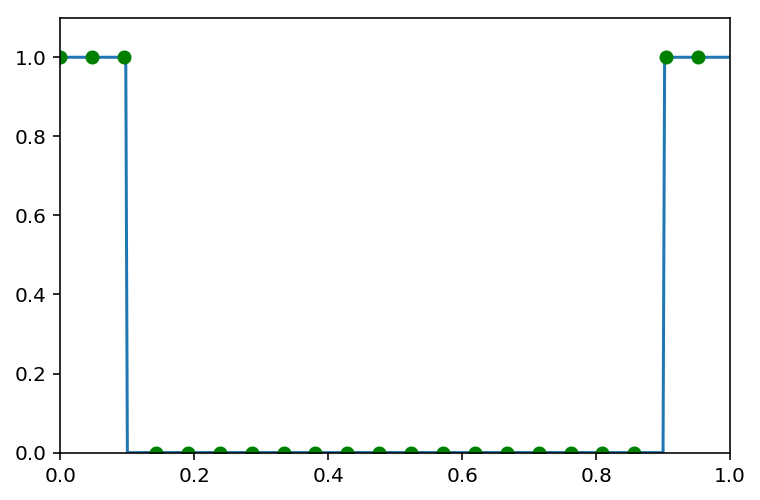

In [6]:
L = 21
#ideal filter
fc = 0.1
N = 20 * L
M = int(np.round(N * fc))
r = np.zeros(N)
r[0:M] = 1
r[-1:-M:-1] = 1
plt.plot(np.arange(0, N) / N, (r))
#sampling the ideal filter
# we want a total of L samples; then step=N//L (integer division)
step = N // L
rs = r[::step]
plt.plot(np.arange(0, N, step) / N, (rs), 'og')
_ = plt.ylim([0, 1.1])
_ = plt.xlim([0, 1])
plt.show()

The associated impulse response is given by the inverse DFT. It is represented on figure \ref{fig:h_sampfreq}.

Impulse response h: [ 0.238  0.217  0.161  0.086  0.013 -0.039 -0.059 -0.048 -0.015  0.021
  0.044  0.044  0.021 -0.015 -0.048 -0.059 -0.039  0.013  0.086  0.161
  0.217]


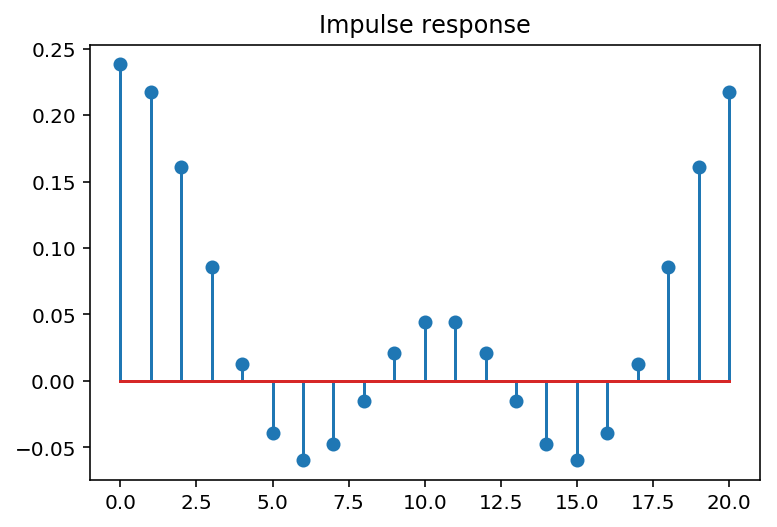

In [7]:
%precision 3
# The impulse response:
h = real(ifft(rs))
print("Impulse response h:", h)
plt.stem(h)
plt.title("Impulse response")
figcaption(
    "Impulse response obtained by frequency sampling", label="fig:h_sampfreq")

This impulse response is periodic, because of the implicit periodicity of sequences after use of a DFT operation. The "true" response is symmetric around $n=0$. We can display it using a `fftshift`. 

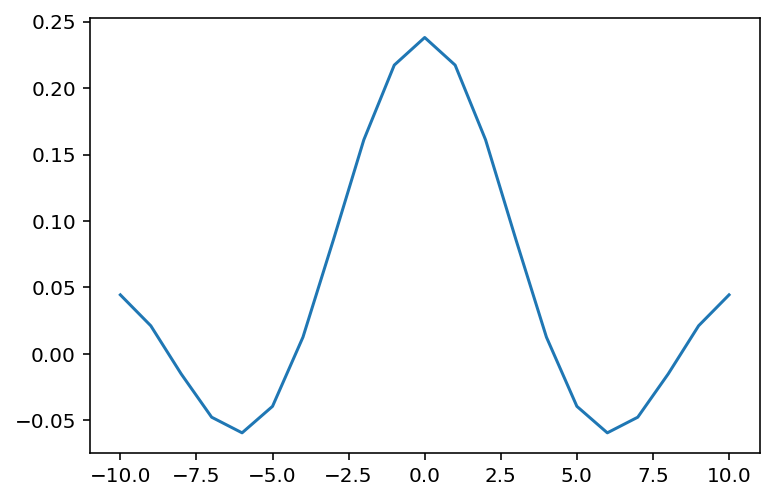

In [8]:
delay = (
    L - 1
) / 2 if L % 2 else L / 2  # delay of L/2 is L is even, (L-1)/2 otherwise
_ = plt.plot(np.arange(0, L) - delay, fftshift(h))

It is very instructive to look at the frequency response which is effectively realized. In other words we must look at what happens between the points. For that, we approximate the discrete time Fourier transform by zero-padding. At this point, it is really important to shift the impulse response because the zero-padding corresponds to an implicit truncation on $L$ points of the periodic sequence, and we want to keep the  true impulse response. This operation introduces a delay of $L/2$ is $L$ is even and $(L-1)/2$ otherwise.  

In [9]:
NN = 1000
H = fft(fftshift(h),
        NN)  ### <-- Here it is really important to introduce a fftshift
### otherwise, the sequence has large transitions 
### on the boundaries

Then we display this frequency response and compare it to the ideal filter and to the frequency samples. 

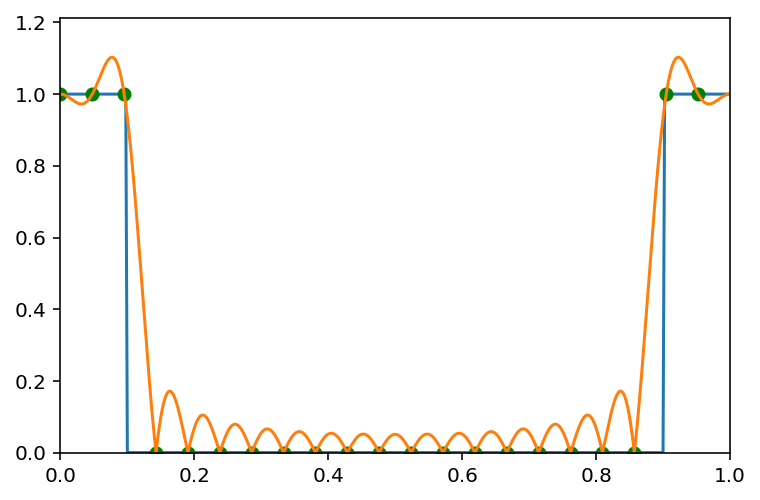

In [10]:
#ideal filter
plt.plot(np.arange(0, N) / N, (r))
#sampling the ideal filter
plt.plot(np.arange(0, N, step) / N, (rs), 'og')
_ = plt.ylim([0, 1.1])
_ = plt.xlim([0, 1])
#realized filter
_ = plt.plot(np.arange(0, NN) / NN, np.abs(H))
_ = plt.ylim([0, 1.1 * np.max(np.abs(H))])

Once we have done all this, we can group all the code into a function and experiment with the parameters, using the  interactive facilities of IPython notebook widgets. 

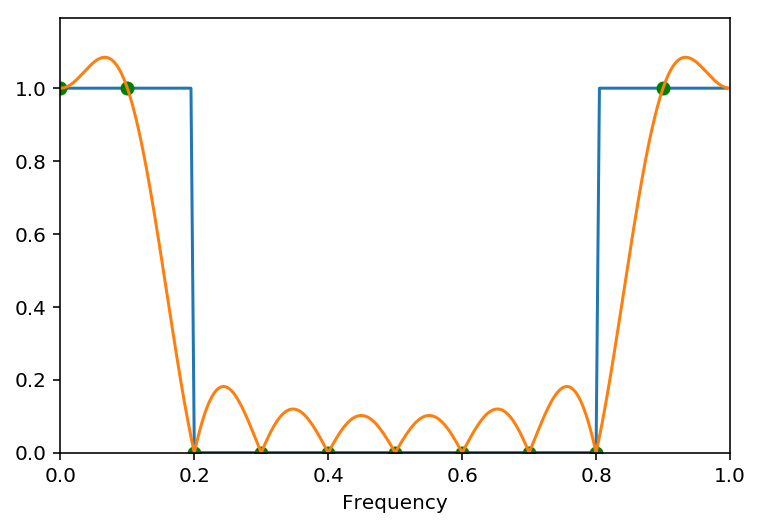

In [11]:
#mpld3.disable_notebook()
def LP_synth_fsampling(fc=0.2, L=20,plot_impresp=False):

    #ideal filter
    N=20*L; M=int(np.round(N*fc))
    r=np.zeros(N); r[0:M]=1; r[-1:-M:-1]=1
    #sampling the ideal filter
    # we want a total of L samples; then step=N//L (integer division)
    step=N//L
    rs=r[::step]
    #clear_output(wait=True)
    
    # The impulse response:
    h=real(ifft(rs))
    if plot_impresp:
        plt.figure()
        %precision 3
        plt.plot(h)
        plt.title("Impulse response")
        
    plt.figure()
    NN=1000
    H=fft(fftshift(h),NN)

    #ideal filter
    plt.plot(np.arange(0,N)/N, (r))
    #sampling the ideal filter
    plt.plot(np.arange(0,N,step)/N, (rs), 'og')
    plt.xlabel("Frequency")
    _=plt.xlim([0, 1])
    #realized filter
    _=plt.plot(np.arange(0,NN)/NN, np.abs(H))
    _=plt.ylim([0, 1.1*np.max(np.abs(H))])
    
_=interact(LP_synth_fsampling, fc=widgets.FloatSlider(min=0, max=1, step=0.01,value=0.2),
         L=widgets.IntSlider(min=1,max=200,value=10), plot_impresp=False)
         


This is a variation on the interactive widgets example, where we do not use the interact function but rather directly the Jupyter widgets. 

In [12]:
from ipywidgets import widgets
out = widgets.Output()

@out.capture(clear_output=True, wait=True)       
def wLP_synth_fsampling():
    fc = fcw.value
    L = Lw.value
    plot_impresp = imprespw.value
    LP_synth_fsampling(fc, L, plot_impresp)
    plt.show()


fcw = widgets.FloatSlider(min=0, max=1, step=0.01, value=0.2, description="fc")
Lw = widgets.IntSlider(min=1, max=200, value=10, description="L")
imprespw = widgets.Checkbox(value=False, description="Show impulse response")
fcw.on_trait_change(wLP_synth_fsampling, name="value")
Lw.on_trait_change(wLP_synth_fsampling, name="value")
imprespw.on_trait_change(wLP_synth_fsampling, name="value")

c = widgets.HBox(children=[fcw, Lw])
#d=widgets.VBox(children=[c,imprespw])
d = widgets.VBox(children=[fcw, Lw, imprespw])
d.align = "center"
d.box_style = "info"
d.layout = Layout(width='40%', align_items='baseline', border_radius=50)

display(widgets.VBox([d, out]))

Widget Javascript not detected.  It may not be installed or enabled properly.


### Synthesis by the window method

The window method for filter design is an easy and robust method. It directly relies on the use of the convolution theorem and its performance are easily understood in terms of the same convolution theorem. 
Since what we need is an impulse response associated with an "ideal" transfer function, the first step consists in computing the discrete-time inverse Fourier transform of the ideal Fourier transform:
$$
H(f) \rightarrow  h(n).
$$

- Of course, this step would require by hand calculations, or a symbolic computation system. This leads to many exercises for students in traditional signal processing. 
- In practice, one often begins with a precise numerical representation of the ideal filter and obtain the impulse response by IDFT. In this sense, the method is linked with synthesis by frequency sampling seen above. 

If we begin with a transfer function which is only specified in magnitude, and if we choose to consider it as purely real, then the impulse response is even, thus non-causal. Furthermore, when the transfer function is band-limited, then its inverse transform has infinite duration. This is a consequence of the uncertainty principle for the Fourier transform. Hence, we face two problems: 
 1. the impulse response is non-causal,
 2. it has infinite support.

$\def\sinc#1{\mathrm{sinc\left(#1\right)}}$
A simple illustration is the following. If we consider an ideal low-pass filter, with cut-off frequency $f_c$, then its inverse Fourier transform is a cardinal sine
$$\displaystyle{
h(n)=2f_c \sinc{2\pi f_c n}.
}
$$

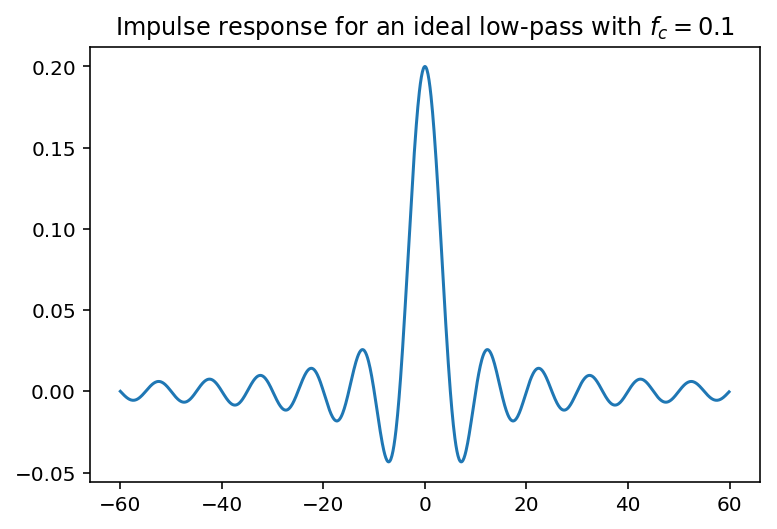

In [13]:
fc=0.1; N=60; n=np.arange(-N,N, 0.1)
plt.plot(n, 2*fc*np.sinc(2*fc*n))
_=plt.title("Impulse response for an ideal low-pass with $f_c={}$".format(fc))

In order to get a finite number of points for our filter, we have no other solution but  truncate the impulse response. Beware that one (you) need to keep both the positive and negative indexes. To get a causal system, it then suffices to shift the impulse response by the length of the non causal part. In the case of our ideal low-pass filter, this gives: 

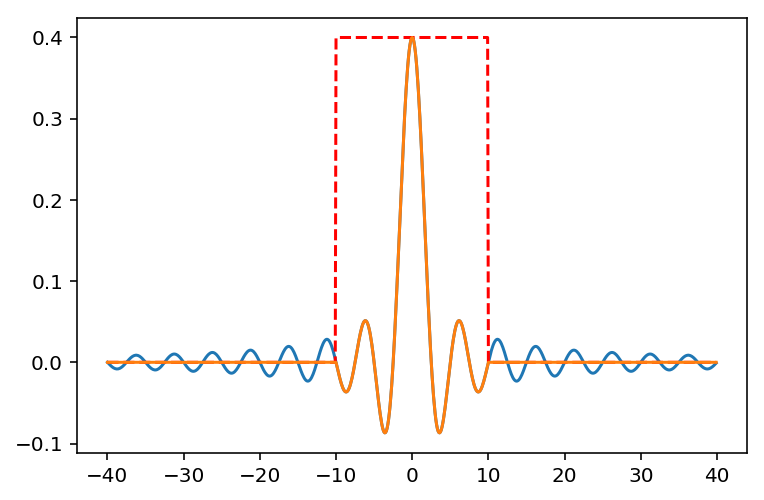

In [14]:
# L: number of points of the impulse response (odd)
L = 21
M = (L - 1) // 2
fc = 0.2
N = 40
step = 0.1
invstep = int(1 / step)
n = np.arange(-N, N, step)
h = 2 * fc * np.sinc(2 * fc * n)
plt.plot(n, h)
w = np.zeros(np.shape(n))
w[where(abs(n * invstep) < M * invstep)] = 1
plt.plot(n, 2 * fc * w, '--r')
ir_w = np.zeros(np.shape(n))
ir_w[where(abs(n * invstep) < M * invstep)] = h[where(
    abs(n * invstep) < M * invstep)]
#plt.figure(); 
_ = plt.plot(n, ir_w)

Then the realized transfer function can be computed and compared with the ideal filter. 

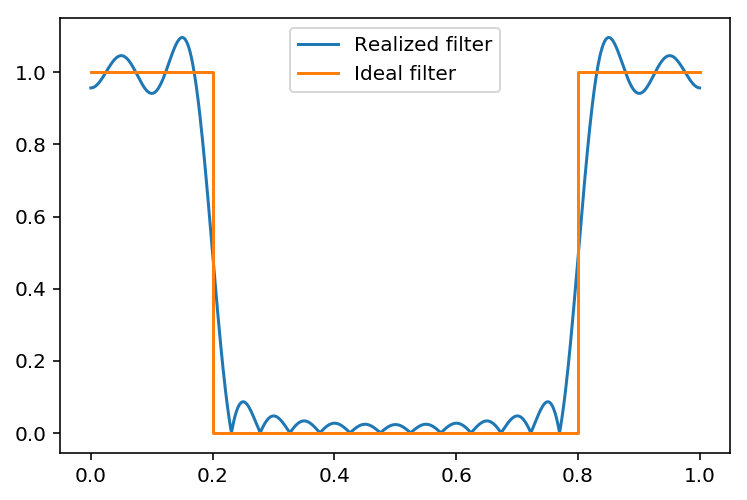

In [15]:
H_w = fft(ir_w[::invstep], 1000)
f = np.linspace(0, 1, 1000)
plt.plot(f, np.abs(H_w), label="Realized filter")
plt.plot(
    [0, fc, fc, 1 - fc, 1 - fc, 1], [1, 1, 0, 0, 1, 1], label="Ideal filter")
_ = plt.legend(loc='best')

We observe that the frequency response presents ripples in both the band-pass and the stop-band. Besides, the transition bandwidth, from the band-pass to the stop-band is large. Again, we can put all the previous commands in the form of a function, and experiment interactively with the parameters. 


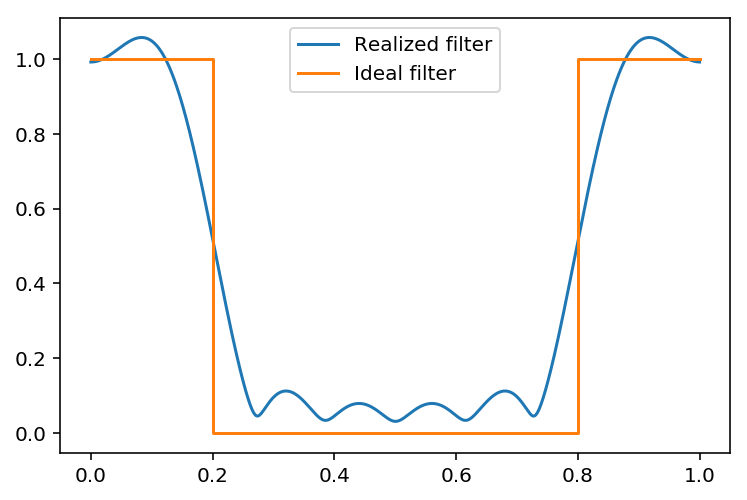

In [16]:
def LP_synth_window(fc=0.2, L=21, plot_impresp=False):

    # L: number of points of the impulse response (odd)
    M = (L - 1) // 2
    step = 0.1
    invstep = int(1 / step)
    n = np.arange(-M - 5, M + 5, step)
    h = 2 * fc * np.sinc(2 * fc * n)
    w = np.zeros(np.shape(n))
    w[where(abs(n * invstep) < M * invstep)] = 1
    ir_w = np.zeros(np.shape(n))
    ir_w[where(abs(n * invstep) < M * invstep)] = h[where(
        abs(n * invstep) < M * invstep)]
    #plt.figure(); 
    if plot_impresp:
        plt.figure()
        plt.plot(n, w, '--r')
        _ = plt.plot(n, ir_w)
        plt.figure()

    H_w = fft(ir_w[::invstep], 1000)
    f = np.linspace(0, 1, 1000)
    plt.plot(f, np.abs(H_w), label="Realized filter")
    plt.plot(
        [0, fc, fc, 1 - fc, 1 - fc, 1], [1, 1, 0, 0, 1, 1],
        label="Ideal filter")
    plt.legend(loc='best')
    #return ir_w


_ = interact(
    LP_synth_window,
    fc=widgets.FloatSlider(
        min=0, max=0.49, step=0.01, value=0.2),
    L=widgets.IntSlider(
        min=1, max=200, value=10),
    plot_impresp=False)

We observe that the transition bandwidth varies with the number of points kept in the imulse response: and that the larger the number of points, the thinner the transition. We also observe that though the ripples oscillations have higher frequency, their amplitude do no change with the number of points.  

There is a simple explanation for these observations, as well as directions for improvement. Instead of the rectangular truncating as above, it is possible to consider more general weight functions, say $w(n)$ of length $N$. The true impulse response is thus *apodized* (literal translation: "removing the foot") by multiplication with the window function:
$$
h_w(n)=h(n)w(n).
$$
By the Plancherel theorem, we immediately get that
$$
H_w(h) = [H*W](f).
$$
The resulting filter is thus the convolution of the ideal response with the Fourier transform of the window function. 

In the example above, the window function is rectangular. As is now well know, its Fourier transform is a discrete cardinal sine (a ratio of two sine)
$$
W(f) = \frac{\sin\left(\pi f (2L+1)\right)}{(2L+1) \sin\left(\pi f \right)}.
$$Hence, the realized filter results from the convolution between the reactangle representing the ideal low-pass with a cardinal sine. This yields that the transition bandwidth is essentially given by the integral of the main lobe of the cardinal sine, and that the amplitude of the ripples are due to the integrals of the sidelobes. In order to improve the synthetiszed filter, we can adjust the number of taps of the impulse response and/or choose another weight window. 

Many window functions have been proposed and are used for the design of FIR filters. These windows are also very useful in spectrum analysis where the same kind of problems -- width of a main lobe, ripples due to the side-lobes, are encountered. A series of windows is presented in the following table. Many other windows exist, and entire books are devoted to their characterization. 

\begin{equation*}
\begin{array}{||l|l|l|l|l||}
\hline\hline 
 \text{Window } & \mathbf{w(n)} &    \mathbf{\Delta f}       &   \mathbf{\text{PSLL}}    \\ 
\hline\hline 
  \text{Rectangular (boxcar)} & 1  &  1   &  -13.252   \\
\hline
  \text{Triangular (Bartlett)} & w(n)=1-(n-(N-1)/2)/N       &  2   &  -26.448
\\
\hline
  \text{Hann} (\cos^2) &   0.5 - 0.5 \cos\left(\frac{2\pi{n}}{M-1}\right) &  2   &   
-31.67 \\ 
\hline
  \text{Nuttal} & --  &  2.98   &  -68.71
 \\ 
\hline
  \text{Hamming} & 0.54 - 0.46 \cos\left(\frac{2\pi{n}}{M-1}\right)  &  3  &  -42.81
 \\ 
\hline
  \text{Bohman} & --  &   3   & -45.99 \\ 
\hline
  \text{Blackman} &  0.42 - 0.5 \cos\left(\frac{2\pi n}{M-1}\right) + 0.08 \cos\left(\frac{4\pi n}{M-1}\right)        
  & 3  &  -58.11 \\
\hline
\text{Flat-top} & --       &  4.96   &  -86.52 \\ 
\hline
\text{Blackman-Harris} & --      &  4   &  -92 \\
\hline\hline 
\end{array}
\end{equation*}

This table present the characteristics of some popular windows. $\Delta f$ represents the width of the main-lobe, normalized to $1/N$. PSLL is the abbreviation of Peal to Side-lobe leakage, and corresponds to the maximum leakage between the amplitude of the main-lobe and the amplitudes of the side-lobes. In the table, we have not reported too complicated  expressions, defined on intervals or so.  For example, the 4 terms Blackman-Harris window, which performs very well, has the expression
$$
w(n) = \sum_{k=0}^3 a_k \cos\left(\frac{2\pi k n}{M-1}\right) 
$$
with $[a_0, a_1, a_2, a_3] = [0.35875, 0.48829, 0.14128, 0.01168]$. The Kaiser-Bessel window function also performs very well. Its expression is 
$$w(n) = I_0\left( \beta \sqrt{1-\frac{4n^2}{(M-1)^2}} \right)/I_0(\beta),$$ where $I_0$ is the modified zeroth-order Bessel function. The shape parameter $\beta$ determines a trade-off between main-lobe width and side lobe level. As $\beta$ gets large, the window narrows.

See the detailed [table](http://books.google.fr/books?id=TYFFAQAAQBAJ&printsec=frontcover&hl=fr#v=snippet&q=162) in the book ``Window Functions and Their Applications in Signal Processing'' by Prabhu (2013).

We have designed a displaying and comparison tool for the window functions. The listing is provided in the appendix, but for now, readers of the IPython notebook version can experiment a bit by issuing the command `%run windows_disp.ipy`. 

In [17]:
"""This is from scipy.signal.get_window() help
List of windows:
boxcar, triang, blackman, hamming, hann, bartlett, flattop,
        parzen, bohman, blackmanharris, nuttall, barthann,
        kaiser (needs beta), gaussian (needs std),
        general_gaussian (needs power, width),
        slepian (needs width), chebwin (needs attenuation)"""
windows=['boxcar', 'triang', 'blackman', 'hamming', 'hann', 'bartlett', 'flattop',
        'parzen', 'bohman', 'blackmanharris', 'nuttall', 'barthann']
windows_1parameter=['kaiser', 'gaussian', 'slepian', 'chebwin']
windows_2parameter=['general_gaussian']

In [18]:
%run windows_disp_jup.ipy

Widget Javascript not detected.  It may not be installed or enabled properly.


The main observation is that with $N$ fixed, we have a trade-off to find between the width of the main lobe, thus of the transition width, and the amplitude of the side-lobes. The choice is usually done on a case by case basis, which may also include other parameters. To sum it all up, the window method consists in:

- calculate (or approximate) the impulse response associated with an ideal impulse response,
- choose a number of samples, and a window function, and apodize the impulse response. The choice of the number of points an window function can also be motivated by maximum level of ripples in the band pass and/or in the stop band.
- shift the resulting impulse response by half the number of samples in order to obtain a causal filter. 


It is quite simple to adapt the previous script with the rectangular window to accept more general windows. This is done by adding a parameter `window`.  

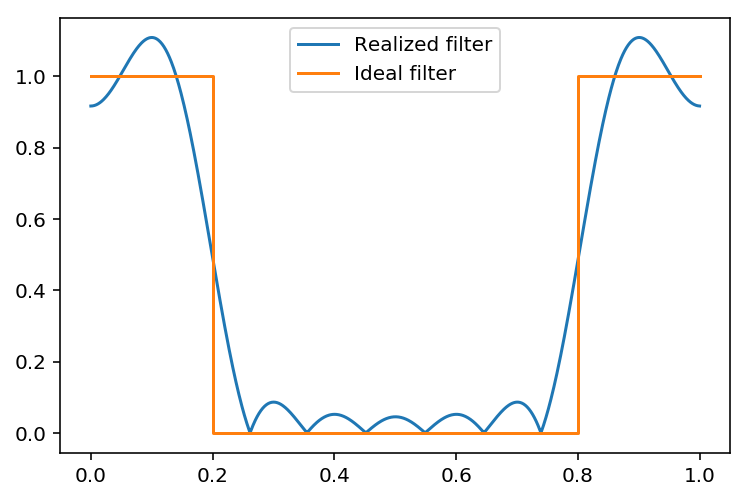

In [19]:
def LP_synth_genwindow(fc=0.2,
                       L=21,
                       window='boxcar',
                       plot_impresp=False,
                       plot_transferfunc=True):

    # L: number of points of the impulse response (odd)

    M = (L - 1) // 2
    step = 1
    invstep = int(1 / step)
    n = np.arange(-M, M + 1, step)
    h = 2 * fc * np.sinc(2 * fc * n)
    w = sig.get_window(window, 2 * M + 1)
    ir_w = w * h
    #plt.figure(); 
    if plot_impresp:
        plt.figure()
        plt.plot(n, w, '--r', label="Window function")
        _ = plt.plot(n, h, label="Initial impulse response")
        _ = plt.plot(n, ir_w, label="Windowed impulse response")
        plt.legend()

    H_w = fft(ir_w[::invstep], 1000)
    if plot_transferfunc:
        plt.figure()
        f = np.linspace(0, 1, 1000)
        plt.plot(f, np.abs(H_w), label="Realized filter")
        plt.plot(
            [0, fc, fc, 1 - fc, 1 - fc, 1], [1, 1, 0, 0, 1, 1],
            label="Ideal filter")
        plt.legend(loc='best')

    return ir_w


w = interactive(
    LP_synth_genwindow,
    fc=widgets.FloatSlider(
        min=0, max=0.49, step=0.01, value=0.2),
    L=widgets.IntSlider(
        min=1, max=200, value=10),
    window=widgets.Dropdown(options=windows),
    plot_impresp=False,
    plot_transferfunc=True)
w

\begin{exercise}
The function `LP_synth_genwindow` returns the impulse response of the synthetized filter. Create a signal $x_\text{test}= \sin(2\pi f_0 n)+\sin(2\pi f_1 n)+\sin(2\pi f_2 n)$, with $f_0=0.14$, $f_1=0.24$, $f_2=0.34$ and filter this signal with the synthetized filter, for $f_c=0.2$, $L=50$, and for a `hamming` window. Comment on the results.
\end{exercise}

Text(0.5, 1.0, 'Filtered signal')

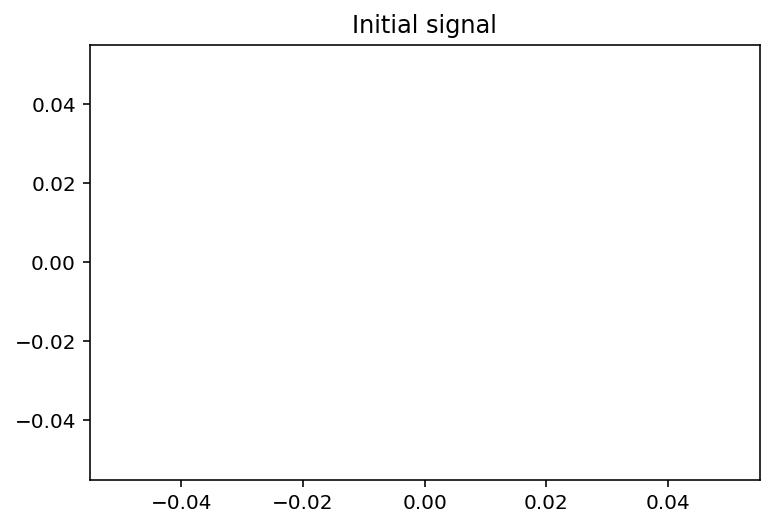

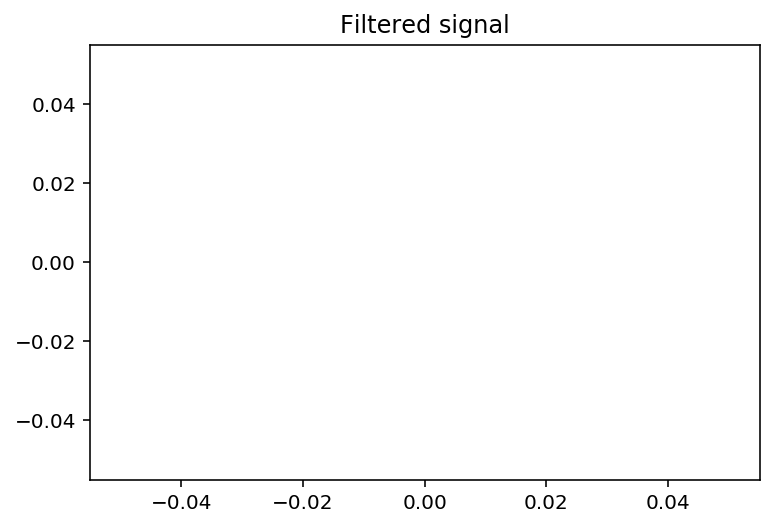

In [20]:
# define constants
n = np.arange(0, 100)
f0, f1, f2 = 0.14, 0.24, 0.34
# the test signal
xtest = 0  # Complete here
plt.plot(xtest)
plt.title("Initial signal")
# compute the filter
#h1 = LP_synth_genwindow(
# Complete here
#)
# then filter the signal
y1 = 0  # Complete here
#and display it
plt.figure()
plt.plot(y1)
plt.title("Filtered signal")

Solution

Text(0.5, 1.0, 'Filtered signal')

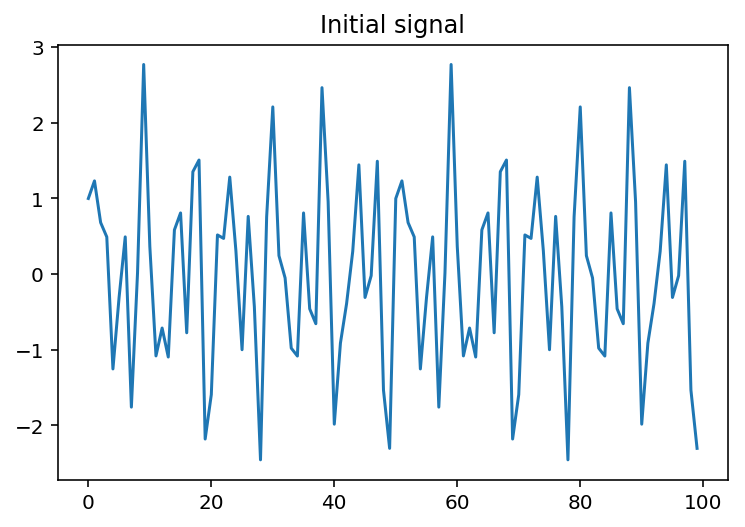

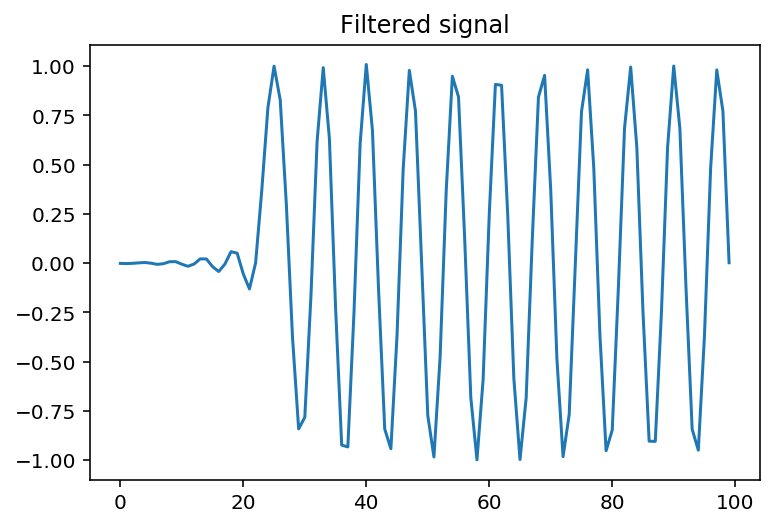

In [21]:
# define constants
n = np.arange(0, 100)
f0, f1, f2 = 0.14, 0.24, 0.34
# the test signal
xtest = sin(2 * pi * f0 * n) + sin(2 * pi * f1 * n) + cos(2 * pi * f2 * n)
plt.plot(xtest)
plt.title("Initial signal")
# compute the filter
h1 = LP_synth_genwindow(
    fc=0.2,
    L=50,
    window='hamming',
    plot_impresp=False,
    plot_transferfunc=False)
# then filter the signal
y1 = sig.lfilter(h1, [1], xtest)
#and display it
plt.figure()
plt.plot(y1)
plt.title("Filtered signal")

The whole synthesis workflow for the window method is available in two specialized functions of the scipy library. Nowadays, it is really useless to redevelop existing programs. It is much more interesting to gain insights on what is really done and how things work. This is actually the goal of this lecture. The two functions avalaible in `scipy.signal` are `firwin` and `firwin2`. 

\begin{exercise}
Use one of these functions to design a high-pass filter with cut-off frequency at $f_c=0.3$. Filter the preceding signal $x_\text{test}$ and display the results.
\end{exercise}

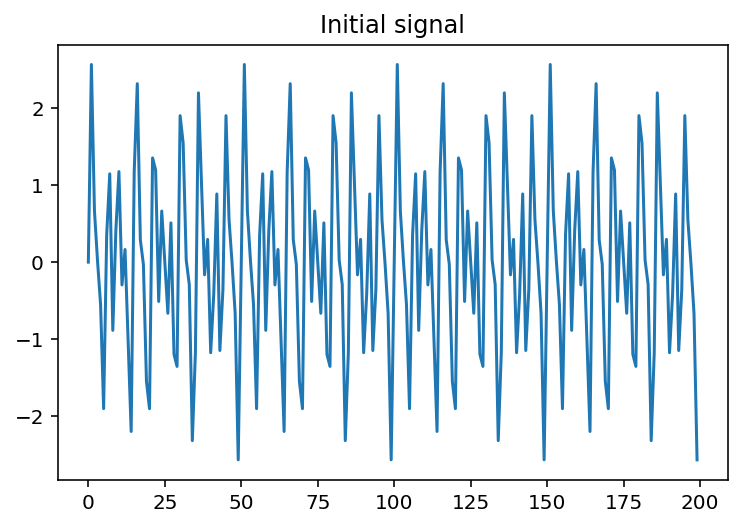

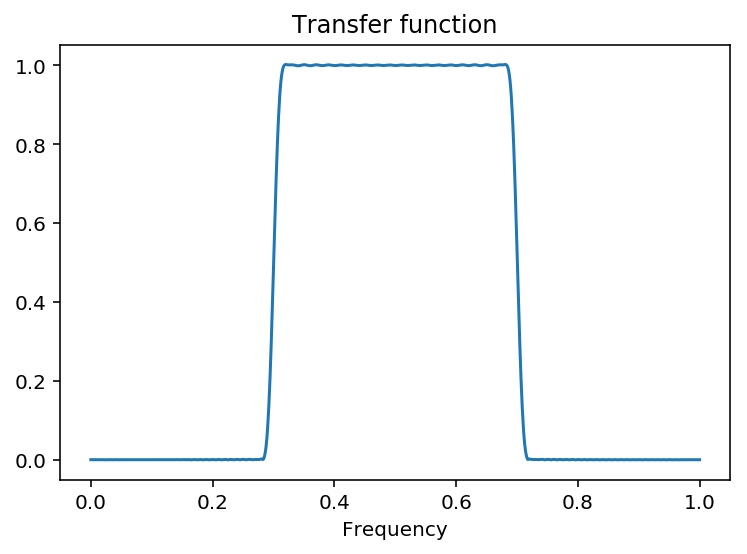

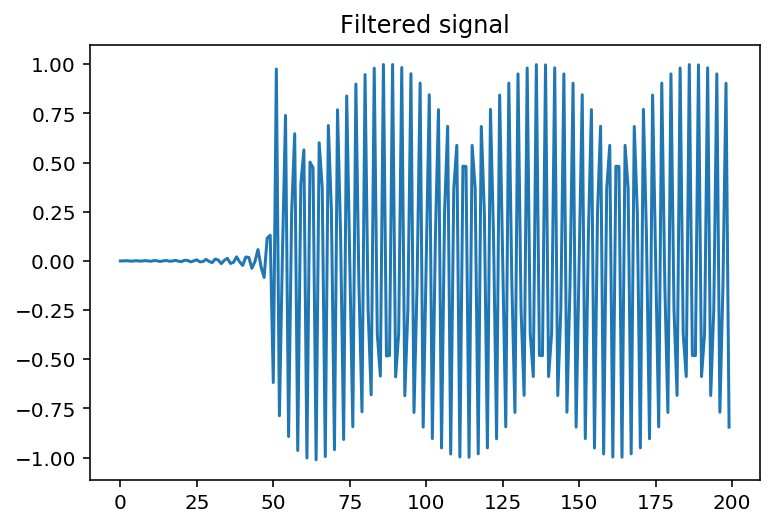

In [22]:
# define constants
n = np.arange(0, 200)
f0, f1, f2 = 0.14, 0.2, 0.34
# the test signal
xtest = sin(2 * pi * f0 * n) + sin(2 * pi * f1 * n) + sin(2 * pi * f2 * n)
plt.plot(xtest)
plt.title("Initial signal")
figcaption("Initial signal")
# compute the filter
h1 = sig.firwin(
    101,
    0.3,
    width=None,
    window='hamming',
    pass_zero=False,
    scale=True,
    nyq=0.5)
plt.figure()
plt.plot(np.linspace(0, 1, 1000), abs(fft(h1, 1000)))
plt.xlabel("Frequency")
plt.title("Transfer function")
figcaption("Transfer function")
# then filter the signal
y1 = sig.lfilter(h1, [1], xtest)
#and display it
plt.figure()
plt.plot(y1)
plt.title("Filtered signal")
figcaption("Filtered signal")


----
<div align=right> [Index](toc.ipynb) - [Back](ZerosPoles.ipynb) - [Next](Bilinear_synthesis.ipynb)</div>